# Spatial transformations and resampling

**Spatial transformations** apply to the image coordinates (voxel or physical space):

$\hspace{20mm} \phi: (X,Y) \rightarrow \phi(X,Y) = (X',Y')$

Similarly, **resampling** apply to the image content and it consists of showing image content on a newly specified coordinates.

$\hspace{20mm} R: I(X,Y) \rightarrow I(X',Y')$

Disclaimer: for simplicity, we use $X$ to refer to rows and $Y$ to refer to columns, even though they do not correspond to the standard cartesian coordinates.

<p>
We will start by selecting a given slice from the previously used brain MRI volume. 
</p>

## 0.- Read, manipulate and visualize images in Python

Let's introduce the three external libraries we will use to read, manipulate and visualize images. Since they are not core Python library, there are two important steps we need to follow:

1.- Install the library. In this tutorial it is done in the activate_environament.sh file

2.- Import them in every Python session we run. The import syntaxis is as follows:

- We can import the whole library by using: __import ext-library as lib1__. For convenience, we can rename the library name to a name of our choice.
- We can import only subparts or functions from an existing library: __from ext-library import basic-function as func1__. For convenience, we can rename the function name to a name of our choice. 


### Nibabel

Nibabel library is an external Python library used to read and write images under common medical and neuroimaging file formats (https://nipy.org/nibabel/)
Nibabel images contain two different fields:
- image content: <class nibabel.arrayproxy.ArrayProxy> the content is not directly loaded on memory, so it uses a proxy. To access to the content we need to map the data object to an numpy array.
- header: <class 'nibabel.nifti1.Nifti1Image'> containing metadata related to acquisiton procotol, acquisition parameter or voxel resolution among many others. Importantly, it contains the affine matrix used to convert the images to the RAS coordinate system.

### NumPy
Python is a programming language whose basic structures include __lists__ but not __arrays__. In order to manipulate arrays we need the NumPy library
NumPy is a widely used external Python library used for numerical operations with multi-dimensional arrays and matrices. It provides a large collection of high-level functions for array manipulation. There exists many similarities between NumPy functions and MATLAB opraterions.
    


### Matplotlib
Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It has many similarities with MATLAB plotting functions.
In this tutorial we will use the pyplot interface.


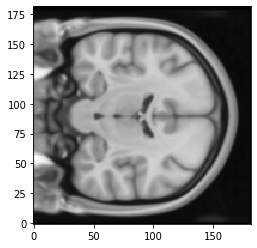

In [1]:
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt

# read a brain MR image
volume = nib.load('../data/MNI152_T1_1mm.nii.gz')

# select a single coronal slice
image_T = np.asarray(volume.dataobj[:, 109, :])

# normalize the image between [0,1] for visualization purposes
image_T = (image_T - np.min(image_T))/(np.max(image_T) - np.min(image_T))

# show the image
plt.figure()
plt.imshow(image_T, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.show()


**Question 1**: why does the image appear rotated? Hint: the RAS projection matrix can be accessed by proxy.affine

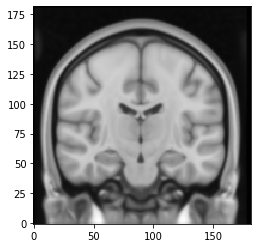

In [3]:
# transpose the image
image = np.transpose(image_T, axes=[1,0])

# show
plt.figure()
plt.imshow(image, cmap='gray',origin='lower',vmin=0, vmax=1)
plt.show()


## 1.- Resampling

_Definition_: resampling is the process of changing the initial sampling scheme in order to obtain a new discrete representation of the underlying continuous signal. In the case of 2-D, 3-D images the sampling scheme referes to the reference grid of pixels/voxels.

This change of the sampling scheme is due to a variety of sources. For example, we may want to represent the images in a different resolution (up-, down-sampling). Another widely used application in medical imaging is to manipulate images using spatial transfromations (e.g., registration).

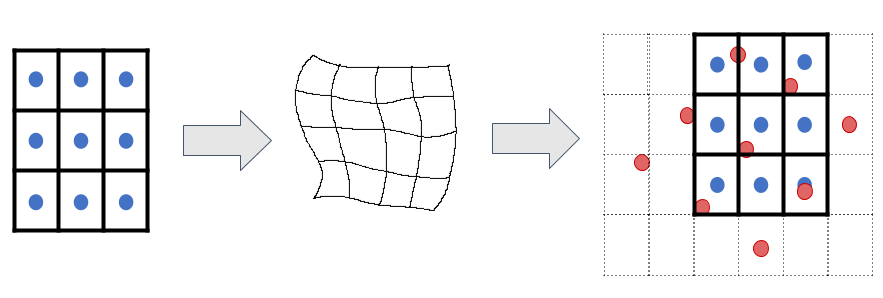


In order to resample an image we first have to define the initial, reference sample grid. For each pixel we need their coordinates (x,j) and thus we need two coordinate maps: X, Y.

Example: imagine we have a 3x3 image. Its reference coordinates (sampling grid) would be specified as: 

\begin{equation}
\text{REF}_{\text{grid}}=
\begin{bmatrix}
 (0,0) & (0,1) & (0,2) \\ 
 (1,0) & (1,1) & (0,2) \\  
 (2,0) & (2,1) & (0,2)    
 \end{bmatrix} = \begin{bmatrix} X & Y\end{bmatrix} = \left(
 \begin{bmatrix}
 0 & 0 & 0 \\ 
 1 & 1 & 1 \\  
 2 & 2 & 2  
 \end{bmatrix},
 \begin{bmatrix}
 0 & 1 & 2 \\ 
 0 & 1 & 2 \\  
 0 & 1 & 2    
 \end{bmatrix} \right)
\end{equation}




In order to compute the spatial coordinates, we use the function _meshgrid_ available in several external libraries in any programming language. In Python, we will use the NumPy library.




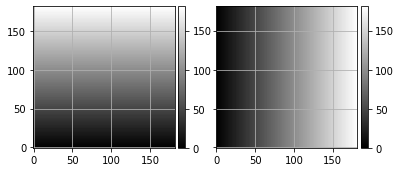

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # plotting

# Create reference grid
XX, YY = np.meshgrid(np.arange(0, image.shape[0]), np.arange(0, image.shape[1]), indexing='ij')
image_coordinates = np.concatenate((XX.reshape(-1,1), YY.reshape(-1,1)), axis=1)

# Show reference grid
fig, ax = plt.subplots(1, 2)
im_ax_0 = ax[0].imshow(XX, cmap='gray',origin='lower')
im_ax_1 = ax[1].imshow(YY, cmap='gray',origin='lower')

ax[0].grid()
ax[1].grid()

for a in ax.flat:
    a.label_outer()

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im_ax_0, cax=cax)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im_ax_1, cax=cax)

plt.show()

There exists several libraries for interpolation. In this tutorial, we will use the interpolation function _interpn_ from the _scipy_ library. This function has 3 mandatory and 3 optional parameters:
<pre><code>
interpn(points, values, xi, method="linear", bounds_error=True, fill_value=np.nan):
   Parameters:
   - points: tuple of vectors of each dimension of the reference grid (X,Y)
   - values: image content defined over the reference grid I(X,Y) 
   - xi: new grid of points (X',Y')
   - method: interpolation method ['linear', 'nearest', 'spline2d']
   - bounds_error: allow pixels from coordinates outside the reference coordinates to appear in the final image
   - fill_value (linked to bounds_error): value to fill pixels from outside the bounds of the 
                                          reference coordinates.
   Return:
   - interpolated_image_flat: the interpolated image as a vector instead of image. We'll need to reshape it.

</code></pre>

Let's do a quick check resampling on the same reference coordinates. The expected MSE=0

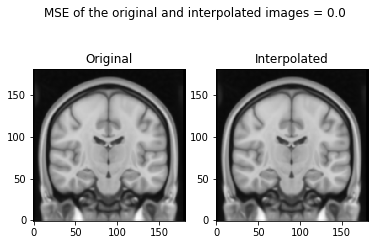

In [5]:
from scipy.interpolate import interpn

# interpolation parameters
points_i = np.arange(0, image.shape[0])
points_j = np.arange(0, image.shape[1])

points = (points_i, points_j)
values = image
xi = np.concatenate((XX.reshape(-1,1), YY.reshape(-1,1)), axis=1)

# interpolation
image_interpn_flatten = interpn(points, values, xi)
image_interpn = image_interpn_flatten.reshape(image.shape)

# show the result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_interpn, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Interpolated')
fig.suptitle('MSE of the original and interpolated images = ' + str(np.mean((image - image_interpn)**2)))
plt.show()


## 2.- Affine transformations

In contrast to intensity transformations, that apply to content (pixel, voxel) values, we refer to spatial transformations that apply to coordinated. In this case, affine transformations involve any linear combination of the reference coordinates. 

\begin{equation}
\begin{bmatrix} x' \\ y' \end{bmatrix} = A\begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix} =  \begin{bmatrix} A & t \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \hat{A}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{equation}

where $A \in \mathbb{R}^{2x2}$ and $t = [t_x t_y]^{T} \in \mathbb{R}^{2x1}$, representing a total of 6 free parameters.

Normally, it is specified using squared matrices
\begin{equation}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =  \begin{bmatrix} A & t \\ 0,...,0 & 1\end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} =  M \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{equation}

Hence, the matrix M has 6 degrees of freedom to model different effects such that (and not limited to): 
- Rotation
- Rigid
- Similarity
- Affine transformations.


In [6]:
# Let's begin with specifying the coordinates [x,y,1]
image_coordinates = np.concatenate((XX.reshape(-1,1), YY.reshape(-1,1), np.ones((np.prod(image.shape), 1))), axis=1).T
print(image_coordinates.shape)

(3, 33124)


### 2.1.- Translation
Special case of the linear transformations, with only 2 parameters: the translation parameters $(t_x, t_y)$. Then, matrix $M$ reads as follows:

\begin{equation}
 M = M_{rot} = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y  \\ 0 & 0 & 1 \end{bmatrix}
\end{equation}

Let's consider the case of $t_x$ = 40, $t_y=-60$

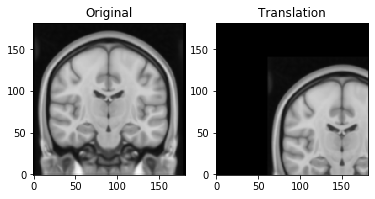

In [7]:
# translation matrix
Mtrans = np.eye(3)
Mtrans[0,2] = 40 # cos(angle)
Mtrans[1,2] = -60 # -sin(angle)

# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.dot(Mtrans, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_trans = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_trans, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Translation')
plt.show()

### 2.2.- Rotation

Special case of the linear transformations, with only 1 parameter: the angle of rotation $\alpha$. Then, matrix $M$ reads as follows:

\begin{equation}
 M = M_{rot} = \begin{bmatrix} cos(\alpha) & -sin(\alpha) & 0 \\ sin(\alpha) & cos(\alpha) & 0  \\ 0 & 0 & 1 \end{bmatrix}
\end{equation}

Let's consider the case of $\alpha=45º$

In [8]:
# rotation matrix: angle=45º
Mrot = np.eye(3)
Mrot[0,0] = 1/np.sqrt(2) # cos(angle)
Mrot[0,1] = -1/np.sqrt(2) # -sin(angle)
Mrot[1,0] = 1/np.sqrt(2) # sin(angle)
Mrot[1,1] = 1/np.sqrt(2) # cos(angle)
print(Mrot)

[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


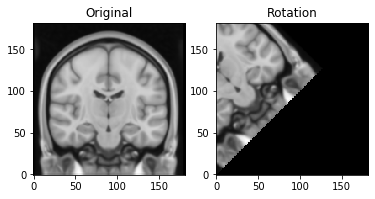

In [9]:
# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.dot(Mrot, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_rotation = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_rotation, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Rotation')
plt.show()


Clearly, it is not the expected result. See that the rotation angle is 45º with respect the origin (0,0). For that, we need to concatenate transformations:

- Center the image (translation) $M_{trans}$
- Apply the transform $M_{rot}$
- Go back to the original space (inverse translation) $M_{trans}^{-1}$

$M = M_{trans}^{-1}M_{rot}M_{trans}$

In that case, it's easy to build the inverse transform of a translation, as it is just a change of sign (intuitively, we see that if we move 3 pixels to the right, the inverse transform is to move three pixels to the left). Let's try it out:

In [10]:
# demo that M_trans^{-1}M_trans=I 
M_trans = np.eye(3)
M_trans[0, 2] = -3
M_trans[1, 2] = -3

M_inv_trans = np.eye(3)
M_inv_trans[0, 2] = 3
M_inv_trans[1, 2] = 3

I = np.eye(3)

M = np.dot(M_trans, M_inv_trans)
error = M - I
print('Error: ' + str(np.sum(error)) + ' pixels.')

Error: 0.0 pixels.


Hence, we just need to specify the center of the image. In that case is simply:

In [11]:
def compute_center(shape):
    return tuple([s // 2 for s in shape])

# centering transformation
center = compute_center(image.shape)
centering_tf = np.eye(3)
centering_tf[0, 2] = 0 - center[0]
centering_tf[1, 2] = 0 - center[1]

# inverse centering transformation
centering_tf_inv = np.eye(3)
centering_tf_inv[0, 2] = -centering_tf[0, 2]
centering_tf_inv[1, 2] = -centering_tf[1, 2]

print('Image shape: ' + str(image.shape))
print('Image center: ' + str(center))

Image shape: (182, 182)
Image center: (91, 91)


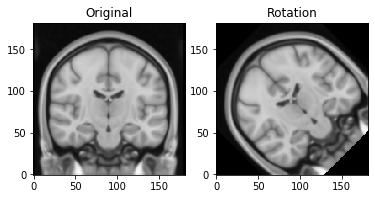

In [12]:
# centered rotation matrix
M = np.dot(centering_tf_inv, np.dot(Mrot, centering_tf))

# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.dot(M, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_rotation = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_rotation, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Rotation')
plt.show()

### 2.2.- Rigid Transformations

Special case of the linear transformations composing rotation and translation. It consists of 3 parameters: the angle of rotation $\alpha$ and the translation parameters $(t_x, t_y)$. Then, matrix $M$ reads as follows:

\begin{equation}
 M = M_{rig} = M_{rot} \cdot M_{trans} = \begin{bmatrix} cos(\alpha) & -sin(\alpha) & t_x \\ sin(\alpha) & cos(\alpha) & t_y  \\ 0 & 0 & 1 \end{bmatrix}
\end{equation}

Let's consider the case of $\alpha=45º$, $t_x$ = 40, $t_y=-60$

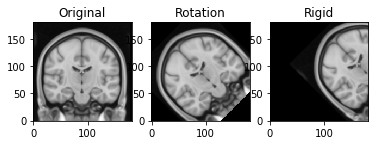

In [13]:
# rigid transformation matrix
Mrig = np.eye(3)
Mrig[0,0] = 1/np.sqrt(2)
Mrig[0,1] = -1/np.sqrt(2)
Mrig[1,0] = 1/np.sqrt(2)
Mrig[1,1] = 1/np.sqrt(2)
Mrig[0,2] = 40
Mrig[1,2] = -60
M = np.dot(centering_tf_inv, np.dot(Mrig, centering_tf))

# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.dot(M, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_rigid = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_rotation, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[2].imshow(image_rigid, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Rotation')
ax[2].title.set_text('Rigid')
plt.show()

### 2.3.- Similarity transformations
Special case of the linear transformations composing rotation, translation and scaling. It consists of 4 parameters: the angle of rotation $\alpha$ and the translation parameters $(t_x, t_y)$ and the scaling factor $s$. Then, matrix $M$ reads as follows:

\begin{equation}
 M = M_{sim} = M_{sc} \cdot M_{rig} =  \begin{bmatrix} s & 0 & 0 \\ 0 & s & 0  \\ 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} cos(\alpha) & -sin(\alpha) & t_x \\ sin(\alpha) & cos(\alpha) & st_y  \\ 0 & 0 & 1 \end{bmatrix}
= \begin{bmatrix} s\cdot cos(\alpha) & -s\cdot sin(\alpha) & s\cdot t_x \\ s\cdot sin(\alpha) & s\cdot cos(\alpha) & s\cdot t_y  \\ 0 & 0 & 1 \end{bmatrix}
\end{equation}

Let's consider the case of $\alpha=45º$, $t_x$ = 40, $t_y=-60$

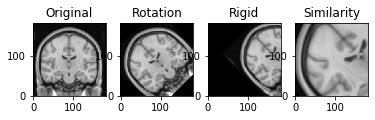

In [14]:
# similarity transformation matrix
s = 0.5
Mrig = np.eye(3)
Mrig[0,0] = 1/np.sqrt(2)
Mrig[0,1] = -1/np.sqrt(2)
Mrig[1,0] = 1/np.sqrt(2)
Mrig[1,1] = 1/np.sqrt(2)
Mrig[0,2] = 40
Mrig[1,2] = -60
Msc = np.eye(3)
Msc[0,0] = s
Msc[1,1] = s
Msim = np.dot(Msc, Mrig)
M = np.dot(centering_tf_inv, np.dot(Msim, centering_tf))

# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.dot(M, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_sc = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 4)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_rotation, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[2].imshow(image_rigid, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[3].imshow(image_sc, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Rotation')
ax[2].title.set_text('Rigid')
ax[3].title.set_text('Similarity')
plt.show()

### 2.4.- Affine Transformations
General case of a linear transform with 6 degrees of freedom composing a variety of transformations: 
- translation
- rotation
- scaling
- similarity
- reflection
- homothety
- shear 

Then, matrix 𝑀 reads as follows:
\begin{equation}
 M = M_{aff} = \begin{bmatrix} a & b & c \\ d & e & f  \\ 0 & 0 & 1 \end{bmatrix} 
\end{equation}

Let's consider random parameters:

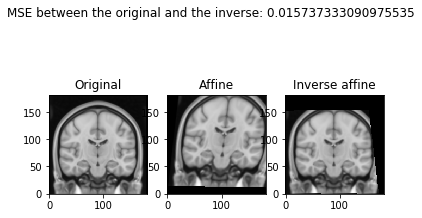

In [19]:
# affine transform
Maff = np.eye(3)
Maff[0,0] = 1 + 0.1*np.random.randn(1)
Maff[0,1] = 0.1*np.random.randn(1)
Maff[1,0] = 0.1*np.random.randn(1)
Maff[1,1] = 1 + 0.1*np.random.randn(1)
Maff[0,2] = 10*np.random.randn(1)
Maff[1,2] = 10*np.random.randn(1)

M = np.dot(centering_tf_inv, np.dot(Maff, centering_tf))

# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.dot(M, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_aff = image_interpn_flatten.reshape(image.shape)

# inverse affine transform
Maff_inv = np.linalg.inv(Maff)
M_inv = np.dot(centering_tf_inv, np.dot(Maff_inv, centering_tf))

# interpolation parameters
points = (points_i, points_j)
values = image_aff
xi = np.dot(M_inv, image_coordinates)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_aff_inv = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_aff, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[2].imshow(image_aff_inv, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Affine')
ax[2].title.set_text('Inverse affine')
plt.suptitle('MSE between the original and the inverse: ' + str(np.mean((image-image_aff_inv)**2)))
plt.show()

Even though the transformation and its inverse are computed correctly, we may incur errors when the image goes outside the image boundaries.

To account for that, we could initially increase the field of view of the image by e.g., padding.


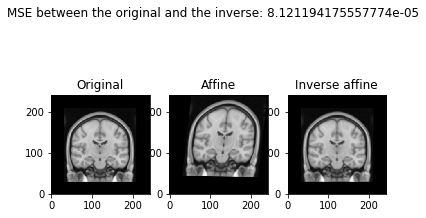

In [20]:
# interpolation parameters
image_pad = np.pad(image, [(30,30),(30,30)])
points_i_pad = np.arange(image_pad.shape[0])
points_j_pad = np.arange(image_pad.shape[1])

XX_pad, YY_pad = np.meshgrid(np.arange(0, image_pad.shape[0]), np.arange(0, image_pad.shape[1]), indexing='ij')
image_coordinates_pad = np.concatenate((XX_pad.reshape(-1,1), YY_pad.reshape(-1,1), np.ones((np.prod(image_pad.shape), 1))), axis=1).T

center_pad = compute_center(image_pad.shape)
centering_tf_pad = np.eye(3)
centering_tf_pad[0, 2] = 0 - center_pad[0]
centering_tf_pad[1, 2] = 0 - center_pad[1]

centering_tf_inv_pad = np.eye(3)
centering_tf_inv_pad[0, 2] = -centering_tf_pad[0, 2]
centering_tf_inv_pad[1, 2] = -centering_tf_pad[1, 2]

M_pad = np.dot(centering_tf_inv_pad, np.dot(Maff, centering_tf_pad))

# interpolation parameters
points = (points_i_pad, points_j_pad)
values = image_pad
xi = np.dot(M_pad, image_coordinates_pad)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_aff_pad = image_interpn_flatten.reshape(image_pad.shape)

# inverse transform
Maff_inv_pad = np.linalg.inv(Maff)
M_inv_pad = np.dot(centering_tf_inv_pad, np.dot(Maff_inv_pad, centering_tf_pad))

# interpolation parameters
points = (points_i_pad, points_j_pad)
values = image_aff_pad
xi = np.dot(M_inv_pad, image_coordinates_pad)[:2].T # new coordinates from the matrix multiplication

# interpolation
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_aff_inv_pad = image_interpn_flatten.reshape(image_pad.shape)

# visualixation
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image_pad, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(image_aff_pad, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[2].imshow(image_aff_inv_pad, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('Affine')
ax[2].title.set_text('Inverse affine')
plt.suptitle('MSE between the original and the inverse: ' + str(np.mean((image_pad-image_aff_inv_pad)**2)))
plt.show()

## 3.- Dense transformations

Dense transformations are the most general case, where there are two parameters for each pixel:

$$\phi(X,Y) = (X + F_x, Y + F_y)$$

where $F_x,F_y$ are full-sized images with a paramater for each coordinate. 

Typically, a smoothness constrain is used in order to regularize the transformation such that they look more plausible/natural and preserve most of the image content. A way to do so is to use control points, such that we compute the deformation on this control points and interpolate in between. Here, we will use linear interpolation from a low resolution deformation field of 5x5

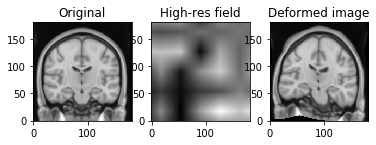

In [21]:
from skimage.transform import resize as imresize

dense_field_res_i = 5*np.random.randn(5,5) # low resolution X field
dense_field_res_j = 5*np.random.randn(5,5) # low resolution Y field
dense_field_res_I = imresize(dense_field_res_i,image.shape) # high resolution X field
dense_field_res_J = imresize(dense_field_res_j,image.shape) # high resolution Y field
XX_new = XX + dense_field_res_I # new coordinates
YY_new = YY + dense_field_res_J # new coordinates

# interpolation parameters
points = (points_i, points_j)
values = image
xi = np.concatenate((XX_new.reshape(-1,1), YY_new.reshape(-1,1)), axis=1)

# interpolation 
image_interpn_flatten = interpn(points, values, xi, bounds_error=False, fill_value=0)
image_interpn = image_interpn_flatten.reshape(image.shape)

# visualization
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[1].imshow(dense_field_res_I, cmap='gray',origin='lower')
ax[2].imshow(image_interpn, cmap='gray',origin='lower', vmin=0, vmax=1)
ax[0].title.set_text('Original')
ax[1].title.set_text('High-res field')
ax[2].title.set_text('Deformed image')
plt.show()

